In [1]:
# Python 2 / 3 compatibility
from __future__ import print_function
from __future__ import division

import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import layers as kl
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils import to_categorical

%matplotlib inline

/home/sumit/Venv/mlpy3venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dataset_pd = pd.read_csv("songdata.csv", )
dataset_pd.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [3]:
del(dataset_pd['link'])
dataset_pd.head()

,artist,song,text
0,ABBA,Ahe's My Kind Of Girl,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante","Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,Making somebody happy is a question of give an...


In [4]:
dataset_pd.describe()

,artist,song,text
count,57650,57650,57650
unique,643,44824,57494
top,Donna Summer,Have Yourself A Merry Little Christmas,I've got sunshine on a cloudy day \nWhen it's...
freq,191,35,6


In [5]:
artist_counts = dataset_pd \
    .groupby(["artist"]) \
    .size() \
    .reset_index(name="counts") \
    .sort_values("counts", ascending=False)

artist_counts.head()

,artist,counts
103,Donna Summer,191
179,Gordon Lightfoot,189
40,Bob Dylan,188
172,George Strait,188
61,Cher,187


In [6]:
artist_counts.tail()

,artist,counts
136,Exo-K,2
518,U-Kiss,1
591,X-Treme,1
637,Zoe,1
633,Zed,1


(array([ 7.,  6.,  2.,  5.,  6., 11.,  7.,  7., 17.,  6.,  9., 10.,  9.,
         4.,  6.,  8.,  9.,  8., 12.,  2.,  9., 12.,  4.,  6., 12.,  8.,
         4.,  8.,  5.,  3.,  6.,  8.,  5.,  6.,  8.,  4., 12.,  8.,  8.,
         4.,  9.,  2.,  5.,  5., 11.,  6.,  9.,  4., 10.,  2., 11.,  6.,
         6.,  9.,  5.,  6.,  8.,  8., 11.,  2.,  5.,  5.,  4.,  7.,  1.,
         5.,  4.,  2.,  3.,  2.,  2.,  6.,  5.,  6.,  5.,  8.,  8., 10.,
         6.,  3.,  4.,  6., 12.,  7.,  5., 11.,  5., 10.,  8.,  2.,  8.,
         9.,  6.,  5.,  3.,  3.,  6.,  6.,  3.,  1.]),
 array([  1. ,   2.9,   4.8,   6.7,   8.6,  10.5,  12.4,  14.3,  16.2,
         18.1,  20. ,  21.9,  23.8,  25.7,  27.6,  29.5,  31.4,  33.3,
         35.2,  37.1,  39. ,  40.9,  42.8,  44.7,  46.6,  48.5,  50.4,
         52.3,  54.2,  56.1,  58. ,  59.9,  61.8,  63.7,  65.6,  67.5,
         69.4,  71.3,  73.2,  75.1,  77. ,  78.9,  80.8,  82.7,  84.6,
         86.5,  88.4,  90.3,  92.2,  94.1,  96. ,  97.9,  99.8, 101.7,
        

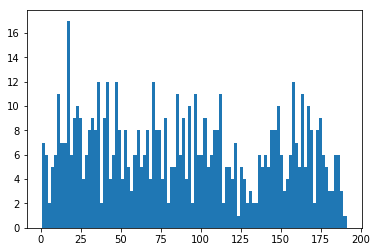

In [7]:
plt.hist(artist_counts["counts"], bins=100)

In [8]:
def fuzzy_search(bands, artist_counts):
    lower_map = {a.lower(): a for a in artist_counts["artist"].values}
    results = []
    bands = [b.lower() for b in bands]
    artist_names = lower_map.keys()
    for b in bands:
        for a in artist_names:
            if (b in a) and (len(b) / len(a) > 0.6):
                actual_name = lower_map[a]
                count = artist_counts["counts"][artist_counts["artist"] == actual_name]
                print("Found %s as %s, Count: %d" % (b, actual_name, count))
                results.append(actual_name)
    return results

In [9]:
favorite_bands = ["Beatles", "ABBA", "Rolling Stones", "Beach Boys", "Eagles", "AC/DC", "Coldplay", "Led Zeppelin"]
BANDS = fuzzy_search(favorite_bands, artist_counts)
print(BANDS)

Found beatles as The Beatles, Count: 178
Found abba as ABBA, Count: 113
Found rolling stones as Rolling Stones, Count: 179
Found beach boys as Beach Boys, Count: 151
Found eagles as Eagles, Count: 41
Found coldplay as Coldplay, Count: 120
['The Beatles', 'ABBA', 'Rolling Stones', 'Beach Boys', 'Eagles', 'Coldplay']


In [10]:
BANDS.remove("Eagles")

In [11]:
dataset_filtered = dataset_pd[dataset_pd["artist"].isin(BANDS)]
dataset_filtered.head()

,artist,song,text
0,ABBA,Ahe's My Kind Of Girl,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante","Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,Making somebody happy is a question of give an...


In [12]:
#Shuffle
dataset_filtered = dataset_filtered.sample(frac=1)
lyrics_X = dataset_filtered["text"].values
artist_Y = dataset_filtered["artist"].values

DATASET_SIZE = len(lyrics_X)

In [13]:
print(artist_Y[:3])

['The Beatles' 'Coldplay' 'Beach Boys']


In [14]:
bands_to_index = {b: i for (i, b) in enumerate(BANDS)}
index_to_bands = {i: b for b, i in bands_to_index.items()}

artist_numeric_Y = [bands_to_index[a] for a in artist_Y]
artist_onehot_Y = to_categorical(artist_numeric_Y)

print("\n-------------\n".join(map(lambda l: l[:200], lyrics_X[:3])))
print(artist_Y[:3])
print(index_to_bands)
print(artist_onehot_Y[:3])

Well, how come you say you will when you won't?  
Say you do, baby when you don't  
Let me know, honey, how you fell  
Tell the truth now, is love real?  
So, aw, aw  
  
Well, honey don't  
Well, hon
-------------
Was a long and dark December  
From the rooftops I remember  
There was snow  
White snow  
  
Clearly I remember  
From the windows they were watching  
While we froze down below  
  
When the future
-------------
We knew it must have been late  
(Tick-tock  
Tick-tock)  
We had no time to wait  
(Tick-tock  
Tick-tock)  
I went to light the fireplace  
(Tick-tock  
Tick-tock)  
I planned it all this way  
And 
['The Beatles' 'Coldplay' 'Beach Boys']
{0: 'The Beatles', 1: 'ABBA', 2: 'Rolling Stones', 3: 'Beach Boys', 4: 'Coldplay'}
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


In [15]:
print(lyrics_X.shape)
print(artist_onehot_Y.shape)

(741,)
(741, 5)


In [16]:
split_lyrics = []
max_lyrics_word_len = 0
for l in lyrics_X:
    split_l = text_to_word_sequence(l)
    max_lyrics_word_len = max(max_lyrics_word_len, len(split_l))
    split_lyrics.extend(split_l)

unique_words_set = set(split_lyrics)

word_counts = {}
for w in unique_words_set:
    word_counts[w] = 0
    
for w in split_lyrics:
    word_counts[w] = word_counts[w] + 1

print('Max lyrics word length: %d' % max_lyrics_word_len)
print('Unique words: %d' % len(unique_words_set))

Max lyrics word length: 611
Unique words: 6741


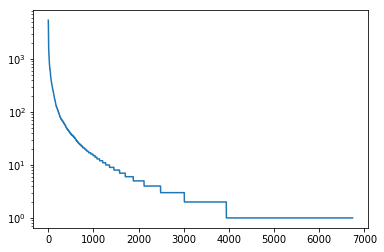

In [17]:
counts_arr = sorted(list(word_counts.values()), reverse=True)
plt.plot(counts_arr)
plt.yscale('log')
plt.show()

In [18]:
def process_dataset(datasetX_lyrics, max_words, max_len):
    print ('Processing dataset, max_words: %d, max_length: %d' % (max_words, max_len))
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(datasetX_lyrics)

    datasetX_tokenized = tokenizer.texts_to_sequences(datasetX_lyrics)
    datasetX_padded = pad_sequences(datasetX_tokenized, maxlen=max_len)

    word_index = tokenizer.word_index
    print('Found %s unique tokens in dataset.' % len(word_index))
    
    return datasetX_padded, tokenizer

In [19]:
datasetX_padded, _ = process_dataset(lyrics_X, 6000, 611)
print('-' * 50)
print(lyrics_X[0])
print(datasetX_padded[0])
print('-' * 50)
print('DatasetX padded shape:', datasetX_padded.shape)

Processing dataset, max_words: 6000, max_length: 611
Found 6741 unique tokens in dataset.
--------------------------------------------------
Well, how come you say you will when you won't?  
Say you do, baby when you don't  
Let me know, honey, how you fell  
Tell the truth now, is love real?  
So, aw, aw  
  
Well, honey don't  
Well, honey don't  
Honey don't  
Honey don't  
Honey don't  
I say you will when you won't  
Aw, aw, honey don't  
  
Well, I love you, baby, and you ought to know  
I like the way that you wear your clothes  
Everything about you is so doggone sweet  
You got that sand all over your feet  
So, aw, aw  
  
Well, honey don't  
Honey don't  
Honey don't  
Honey don't  
Honey don't  
I say you will when you won't  
Aw, aw, honey don't  
  
I feel fine  
Ooo, oo, I say  
Well Sometimes I love you on a Saturday night  
Sunday morning you don't look right  
You been out painting the town  
Uh huh, baby you been slipping around  
So, aw, aw  
  
Well, honey don't  


In [20]:
datasetX_padded[:5]

array([[   0,    0,    0, ...,  944,  150,   23],
       [   0,    0,    0, ...,  131,  353, 1708],
       [   0,    0,    0, ...,  318,  664,  664],
       [   0,    0,    0, ...,  313,   22,    7],
       [   0,    0,    0, ...,   12,    2, 1457]], dtype=int32)

In [21]:
def get_checkpoint_callback(model):
    dir_name = model.name
    if not os.path.isdir(dir_name):
        os.makedirs(dir_name)
    return ModelCheckpoint(
        dir_name + '/weights-epoch-{epoch:02d}-vloss-{val_loss:.2f}.hdf5',
        monitor='val_loss',
        period=1
    )

In [22]:
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')

def get_embedding_layer(tokenizer, embedding_dims, max_words, max_len, trainable=False):
    embeddings_index = {}
    with open(os.path.join(GLOVE_DIR, 'glove.6B.%dd.txt' % embedding_dims)) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))

    # prepare embedding matrix
    word_index = tokenizer.word_index
    num_words = min(max_words, len(word_index))
    embedding_matrix = np.zeros((num_words, embedding_dims))
    for word, i in word_index.items():
        if i >= max_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    # load pre-trained word embeddings into an Embedding layer
    # note that we set trainable = False so as to keep the embeddings fixed
    embedding_layer = kl.Embedding(num_words,
                                embedding_dims,
                                weights=[embedding_matrix],
                                input_length=max_len,
                                trainable=trainable)  
    
    return embedding_layer

In [25]:
TEST_SPLIT = 0.2

EMBEDDING_DIM = 50  # 50 / 100 / 200 / 300
MAX_VOCAB_SIZE = 6741
MAX_SEQ_LENGTH = 611

model_name_suffix = '-%d_dim_emb-%d_vocab' % (EMBEDDING_DIM, MAX_VOCAB_SIZE)

datasetX_padded, tokenizer = process_dataset(lyrics_X, MAX_VOCAB_SIZE, MAX_SEQ_LENGTH)
embedding_layer = get_embedding_layer(tokenizer, EMBEDDING_DIM, MAX_VOCAB_SIZE, MAX_SEQ_LENGTH)

trainX_padded, testX_padded, trainY, testY = train_test_split(
    datasetX_padded,
    artist_onehot_Y,
    test_size=TEST_SPLIT)

sequence_input = kl.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = kl.SpatialDropout1D(0.2)(embedded_sequences)
x = kl.LSTM(128)(x)
x = kl.Dropout(0.5)(x)
x = kl.Dense(128, activation='relu')(x)
x = kl.Dropout(0.5)(x)
preds = kl.Dense(len(BANDS), activation='softmax')(x)

model = Model(sequence_input, preds, name='1_LSTM_128-dense_128' + model_name_suffix)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(
    trainX_padded,
    trainY,
    validation_data=(testX_padded, testY),
    epochs=100,
    batch_size=128,
    callbacks = [
        get_checkpoint_callback(model),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ],
    shuffle=True,
)

Processing dataset, max_words: 6741, max_length: 611
Found 6741 unique tokens in dataset.
Found 400000 word vectors.
Train on 592 samples, validate on 149 samples
Epoch 1/100
592/592 [==============================] - 2s 4ms/step - loss: 1.6683 - acc: 0.1909 - val_loss: 1.5988 - val_acc: 0.2349
Epoch 2/100
592/592 [==============================] - 2s 4ms/step - loss: 1.6103 - acc: 0.2111 - val_loss: 1.5857 - val_acc: 0.2483
Epoch 3/100
592/592 [==============================] - 2s 4ms/step - loss: 1.5985 - acc: 0.2568 - val_loss: 1.5810 - val_acc: 0.2483
Epoch 4/100
592/592 [==============================] - 2s 4ms/step - loss: 1.6129 - acc: 0.2416 - val_loss: 1.5781 - val_acc: 0.3020
Epoch 5/100
592/592 [==============================] - 2s 4ms/step - loss: 1.5840 - acc: 0.2720 - val_loss: 1.5759 - val_acc: 0.3087
Epoch 6/100
592/592 [==============================] - 2s 4ms/step - loss: 1.5793 - acc: 0.2922 - val_loss: 1.5765 - val_acc: 0.3020
Epoch 7/100
592/592 [==================

<table>
    <thead>
        <tr>
            <th style="text-align:center">Model</th>
            <th>Training Loss</th>
            <th>Validation Loss</th>
            <th>Training Accuracy</th>
            <th>Validation Accuracy</th>
            <th>Overfitting</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align:left">
                <pre>
EMBEDDING_DIM = 50
MAX_VOCAB_SIZE = 6741
MAX_SEQ_LENGTH = 611
Input -> Embedding -> SpatialDropout1D(0.2)
-> LSTM(128) -> Dropout(0.5)
-> Dense(128, 'relu') -> Dropout(0.5)
-> Dense(len(BANDS), activation='softmax')
                </pre>
            </td>
            <td style="text-align:center">1.2514</td>
            <td style="text-align:center">1.5306</td>
            <td style="text-align:center">0.4764</td>
            <td style="text-align:center">0.3423</td>
            <td style="text-align:center">High bias,<br/>
                High variance
            </td>
        </tr>
        <tr>
            <td style="text-align:left">
                <pre>
EMBEDDING_DIM = 100
MAX_VOCAB_SIZE = 6000
MAX_SEQ_LENGTH = 600
Input -> Embedding -> SpatialDropout1D(0.2)
-> LSTM(128) -> Dropout(0.5)
-> Dense(128, 'relu') -> Dropout(0.5)
-> Dense(len(BANDS), activation='softmax')
                </pre>
            </td>
            <td style="text-align:center">1.1711</td>
            <td style="text-align:center">1.4861</td>
            <td style="text-align:center">0.5186</td>
            <td style="text-align:center">0.3624</td>
            <td style="text-align:center">High bias,<br/>
                High variance
            </td>
        </tr>
        <tr>
            <td style="text-align:left">
                <pre>
EMBEDDING_DIM = 100
MAX_VOCAB_SIZE = 6000
MAX_SEQ_LENGTH = 600
Input -> Embedding -> SpatialDropout1D(0.2)
-> Bidirectional_LSTM(128) -> Dropout(0.5)
-> Dense(128, 'relu') -> Dropout(0.5)
-> Dense(len(BANDS), activation='softmax')
                </pre>
            </td>
            <td style="text-align:center">1.1926</td>
            <td style="text-align:center">1.5276</td>
            <td style="text-align:center">0.5304</td>
            <td style="text-align:center">0.3490</td>
            <td style="text-align:center">High bias,<br/>
                High variance
            </td>
        </tr>
        <tr>
            <td style="text-align:left">
                <pre>
EMBEDDING_DIM = 200
MAX_VOCAB_SIZE = 6000
MAX_SEQ_LENGTH = 600
Input -> Embedding -> SpatialDropout1D(0.2)
-> Bidirectional_LSTM(128) -> Dropout(0.5)
-> Dense(128, 'relu') -> Dropout(0.5)
-> Dense(len(BANDS), activation='softmax')
                </pre>
            </td>
            <td style="text-align:center">0.9014</td>
            <td style="text-align:center">1.6976</td>
            <td style="text-align:center">0.6689</td>
            <td style="text-align:center">0.3557</td>
            <td style="text-align:center">Definitely high variance,<br/>
                could be high bias<br/>
                (but cannot say for<br/>
                sure as human performance<br/>
                is not known for this problem)
            </td>
        </tr>
    </tbody>
</table>